# Teste prático Data Science - Intelivix

## Adilson Angelo

In [19]:
import pandas as pd
import seaborn as sns
import math

In [2]:
train_data = pd.read_csv('data/train.tsv', sep='\t', index_col='Id')
test_data = pd.read_csv('data/test.tsv', sep='\t', index_col='Id')
print(train_data.shape)
train_data.sample(frac=.01, random_state=42).head()

(156060, 3)


,IdSentenca,Texto,Sentimento
Id,,,
95723,5000,'s as sorry,2
147313,8016,Romantic comedy and Dogme 95 filmmaking may se...,4
36992,1752,of these days,2
150212,8182,flinch from its unsettling prognosis,2
140656,7631,are clinically depressed,1


In [3]:
print(train_data['Sentimento'].value_counts(normalize=True))
train_data['Sentimento'].value_counts()

2    0.509945
3    0.210989
1    0.174760
4    0.058990
0    0.045316
Name: Sentimento, dtype: float64


2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentimento, dtype: int64

## Pre-processamento

### Stemming

Stemming para reduzir o número de features e usar apenas os radicais mais significantes
utilizando a mesma regex (`(?u)\b\w\w+\b`) que é usada no algoritmo de TF-IDF do sklearn para tokenizar

In [4]:
import re
import nltk

def stemmer(string):
    stmmr = nltk.stem.porter.PorterStemmer()
    tokens = (re.findall(r'(?u)\b\w\w+\b', string))
    stemmed = ' '.join([stmmr.stem(w) for w in tokens])
    return stemmed

### Vetorizando o dataset pelo algoritmo TF-IDF
- Foi escolhido o TF-IDF pelo trade-off entre relevância e frequência dos termos
- O uso de stop words nesse caso não surtiu grande efeito, o tuning nos parâmetros max_df e min_df tiveram melhores resultados
- também foram considerados unigramas e bigramas

In [ ]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("english")

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(preprocessor=stemmer, min_df=10, max_df=.6, ngram_range=(1, 2), sublinear_tf=True)

%time X = vectorizer.fit_transform(train_data['Texto'])

y = train_data['Sentimento']

X.shape

Wall time: 26.7 s


(156060, 33728)

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

### Outlier Detection
- Remoção de outliers para obter melhores classificadores e regressores
- Visto que existe mais de duas classes no problema, o Local Outlier Factor pode detectar os outliers em cada grupamento

In [64]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(contamination=.05, n_jobs=-1)

%time scores = lof.fit_predict(X_train)

Wall time: 14min 33s


In [65]:
scores

array([1, 1, 1, ..., 1, 1, 1])

In [66]:
outX_train = X_train[scores == 1]
outy_train = y_train[scores == 1]

In [67]:
outy_train.shape

(103780,)

### Repeated Edited Nearest Neighbor Rule
- Devido ao tempo consumido por esse algoritmo, e visto que após 2 iterações ele converge, será usada uma única iteração (Edited Nearest Neighbor Rule)
- O objetivo é tirar os vetores que se encontram na zona de indecisão, facilitando assim a melhor definição dos grupamentos no 

In [ ]:
# XX_train = X_train.copy()
# yy_train = y_train.copy()

# from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier(n_neighbors=3, weights='distance', n_jobs=-1)

# for i in range(5):
#     %time knn.fit(XX_train, yy_train)

#     %time yy_pred = knn.predict(XX_train)

#     indexes = np.where(yy_pred == yy_train)[0]
#     yy_train = yy_train.iloc[indexes]
#     XX_train = XX_train[indexes]

### Edited Nearest Neighbor Rule

In [14]:
XX_train = X_train.copy()
yy_train = y_train.copy()

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, weights='distance', n_jobs=-1)

knn.fit(XX_train, yy_train)

%time yy_pred = knn.predict(XX_train)

Wall time: 14min 26s


In [15]:
indexes = np.where(yy_pred == yy_train)[0]
ennry_train = yy_train.iloc[indexes]
ennrX_train = XX_train[indexes]
ennry_train.shape

(102777,)

- Foram escolhidos alguns classificadores e regressores lineares e naive bayes para serem testados empiricamente

## Linear Support Vector Machine

### Classificação
#### Todo dataset

In [68]:
from sklearn import svm

svc = svm.LinearSVC(random_state=42)

svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.34      0.41      2113
           1       0.55      0.48      0.51      8228
           2       0.71      0.83      0.76     23588
           3       0.58      0.52      0.55     10041
           4       0.55      0.38      0.45      2848

    accuracy                           0.65     46818
   macro avg       0.58      0.51      0.54     46818
weighted avg       0.64      0.65      0.64     46818



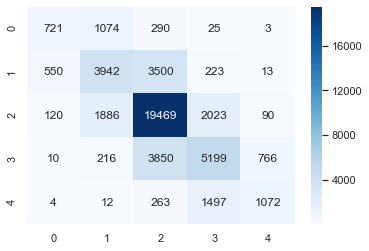

In [69]:
c_m = confusion_matrix(y_test, y_pred)
sns.heatmap(c_m, annot=True, cmap="Blues", fmt="d")

#### Sem outliers

In [70]:
svc.fit(outX_train, outy_train)

y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.34      0.40      2113
           1       0.55      0.47      0.51      8228
           2       0.71      0.82      0.76     23588
           3       0.58      0.51      0.54     10041
           4       0.55      0.38      0.45      2848

    accuracy                           0.65     46818
   macro avg       0.58      0.50      0.53     46818
weighted avg       0.63      0.65      0.63     46818



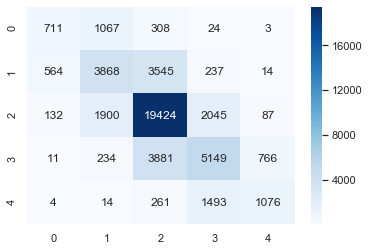

In [71]:
c_m = confusion_matrix(y_test, y_pred)
sns.heatmap(c_m, annot=True, cmap="Blues", fmt="d")

#### ENNR

In [72]:
svc.fit(ennrX_train, ennry_train)

y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.37      0.42      2113
           1       0.55      0.48      0.51      8228
           2       0.71      0.83      0.76     23588
           3       0.58      0.51      0.54     10041
           4       0.56      0.34      0.43      2848

    accuracy                           0.65     46818
   macro avg       0.58      0.51      0.53     46818
weighted avg       0.64      0.65      0.64     46818



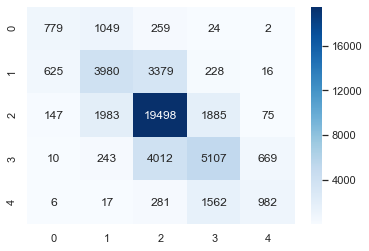

In [73]:
c_m = confusion_matrix(y_test, y_pred)
sns.heatmap(c_m, annot=True, cmap="Blues", fmt="d")

### Regressão
#### Todo dataset

In [74]:
svr = svm.LinearSVR(random_state=42)

svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)

mean_squared_error(y_test, y_pred)

0.3932572720935302

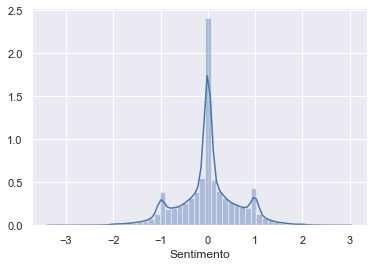

In [75]:
diff = (y_test - y_pred)
sns.set(color_codes=True)
sns.distplot(diff)

#### Sem outliers

In [76]:
svr.fit(outX_train, outy_train)

y_pred = svr.predict(X_test)

mean_squared_error(y_test, y_pred)

0.4001384370545204

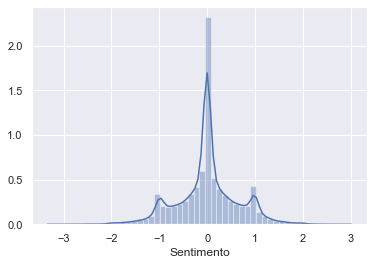

In [77]:
diff = (y_test - y_pred)
sns.set(color_codes=True)
sns.distplot(diff)

#### ENNR

In [78]:
svr.fit(ennrX_train, ennry_train)

y_pred = svr.predict(X_test)

mean_squared_error(y_test, y_pred)

0.3964816759223956

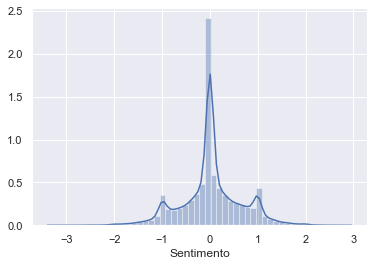

In [79]:
diff = (y_test - y_pred)
sns.set(color_codes=True)
sns.distplot(diff)

## Linear Regression

### Todo dataset

In [80]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(n_jobs=-1)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mean_squared_error(y_test, y_pred)

0.4845217552754087

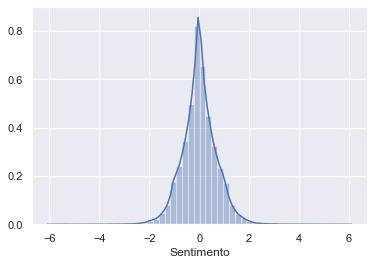

In [81]:
diff = (y_test - y_pred)
sns.set(color_codes=True)
sns.distplot(diff)

### Sem outliers

In [82]:
lr.fit(outX_train, outy_train)

y_pred = lr.predict(X_test)

mean_squared_error(y_test, y_pred)

0.5579498003882088

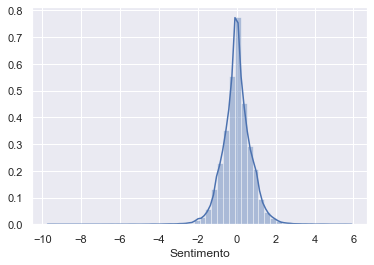

In [83]:
diff = (y_test - y_pred)
sns.set(color_codes=True)
sns.distplot(diff)

### ENNR

In [84]:
lr.fit(ennrX_train, ennry_train)

y_pred = lr.predict(X_test)

mean_squared_error(y_test, y_pred)

0.4902341140993282

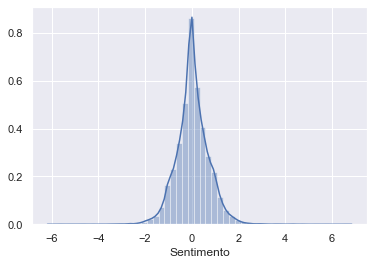

In [85]:
diff = (y_test - y_pred)
sns.set(color_codes=True)
sns.distplot(diff)

## Ridge

### Todo dataset

In [165]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=42)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

mean_squared_error(y_test, y_pred)

0.36505313555766694

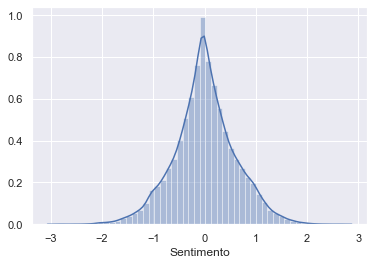

In [166]:
diff = (y_test - y_pred)
sns.set(color_codes=True)
sns.distplot(diff)

### Sem outliers

In [167]:
ridge.fit(outX_train, outy_train)

y_pred = ridge.predict(X_test)

mean_squared_error(y_test, y_pred)

0.3702999460811118

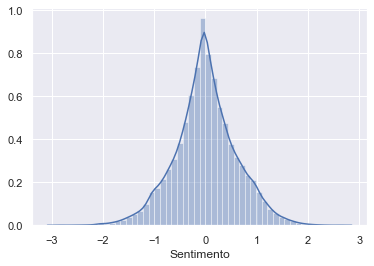

In [168]:
diff = (y_test - y_pred)
sns.set(color_codes=True)
sns.distplot(diff)

### ENNR

In [169]:
ridge.fit(ennrX_train, ennry_train)

y_pred = ridge.predict(X_test)

mean_squared_error(y_test, y_pred)

0.3672448623340852

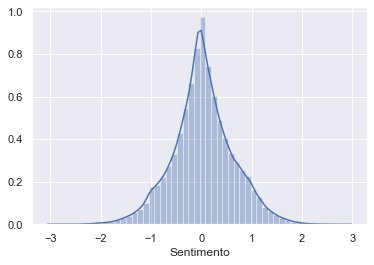

In [170]:
diff = (y_test - y_pred)
sns.set(color_codes=True)
sns.distplot(diff)

## Logistic Regression

### Todo dataset

In [158]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='saga', max_iter=100, class_weight='balanced', n_jobs=-1, C=1e5)

%time logreg = logreg.fit(X_train, y_train)

%time y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred))

c:\users\aange\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\aange\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Wall time: 21.4 s
Wall time: 11 ms
              precision    recall  f1-score   support

           0       0.34      0.55      0.42      2113
           1       0.47      0.51      0.49      8228
           2       0.76      0.65      0.70     23588
           3       0.50      0.55      0.53     10041
           4       0.46      0.49      0.47      2848

    accuracy                           0.59     46818
   macro avg       0.50      0.55      0.52     46818
weighted avg       0.61      0.59      0.60     46818



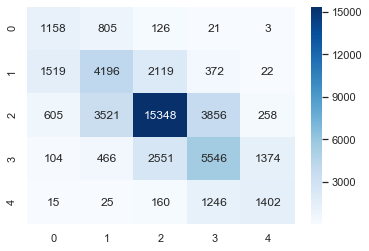

In [159]:
c_m = confusion_matrix(y_test, y_pred)
sns.heatmap(c_m, annot=True, cmap="Blues", fmt="d")

### Sem outliers

In [108]:
logreg = logreg.fit(outX_train, outy_train)

y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.50      0.40      2113
           1       0.45      0.51      0.48      8228
           2       0.74      0.62      0.67     23588
           3       0.47      0.48      0.48     10041
           4       0.37      0.60      0.46      2848

    accuracy                           0.56     46818
   macro avg       0.47      0.54      0.50     46818
weighted avg       0.59      0.56      0.57     46818



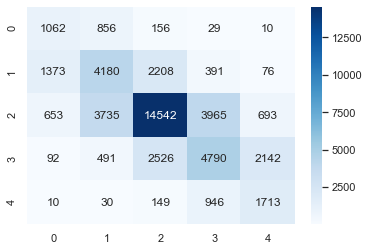

In [109]:
c_m = confusion_matrix(y_test, y_pred)
sns.heatmap(c_m, annot=True, cmap="Blues", fmt="d")

### ENNR

In [110]:
logreg = logreg.fit(ennrX_train, ennry_train)

y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.37      0.49      0.42      2113
           1       0.48      0.52      0.50      8228
           2       0.74      0.68      0.71     23588
           3       0.51      0.52      0.51     10041
           4       0.45      0.49      0.47      2848

    accuracy                           0.60     46818
   macro avg       0.51      0.54      0.52     46818
weighted avg       0.61      0.60      0.60     46818



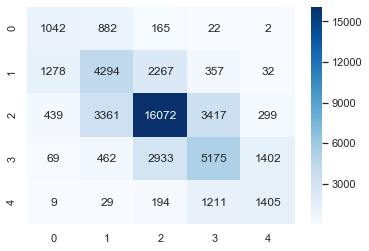

In [111]:
c_m = confusion_matrix(y_test, y_pred)
sns.heatmap(c_m, annot=True, cmap="Blues", fmt="d")

## Rocchio Classifier

### Todo dataset

In [92]:
from sklearn.neighbors import NearestCentroid

ncc = NearestCentroid()

ncc.fit(X_train, y_train)

y_pred = ncc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.48      0.27      2113
           1       0.35      0.31      0.33      8228
           2       0.67      0.61      0.64     23588
           3       0.43      0.26      0.33     10041
           4       0.24      0.55      0.34      2848

    accuracy                           0.48     46818
   macro avg       0.38      0.44      0.38     46818
weighted avg       0.51      0.48      0.48     46818



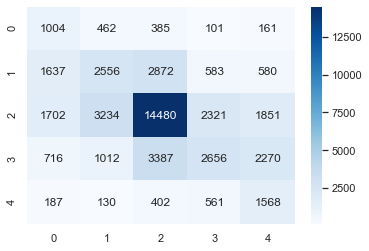

In [93]:
c_m = confusion_matrix(y_test, y_pred)
sns.heatmap(c_m, annot=True, cmap="Blues", fmt="d")

### Sem outliers

In [94]:
ncc.fit(outX_train, outy_train)

y_pred = ncc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.47      0.27      2113
           1       0.35      0.31      0.33      8228
           2       0.67      0.62      0.65     23588
           3       0.43      0.27      0.33     10041
           4       0.25      0.55      0.34      2848

    accuracy                           0.48     46818
   macro avg       0.38      0.44      0.39     46818
weighted avg       0.52      0.48      0.49     46818



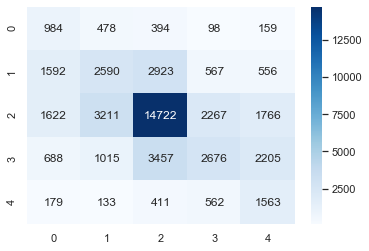

In [95]:
c_m = confusion_matrix(y_test, y_pred)
sns.heatmap(c_m, annot=True, cmap="Blues", fmt="d")

### ENNR

In [96]:
ncc.fit(ennrX_train, ennry_train)

y_pred = ncc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.47      0.28      2113
           1       0.34      0.32      0.33      8228
           2       0.67      0.61      0.64     23588
           3       0.43      0.28      0.34     10041
           4       0.25      0.52      0.34      2848

    accuracy                           0.48     46818
   macro avg       0.38      0.44      0.38     46818
weighted avg       0.51      0.48      0.49     46818



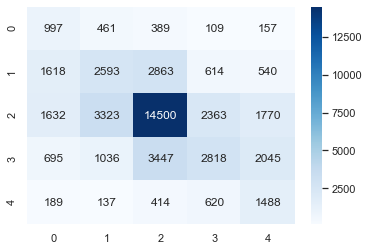

In [97]:
c_m = confusion_matrix(y_test, y_pred)
sns.heatmap(c_m, annot=True, cmap="Blues", fmt="d")

## Naive Bayes

### Classification

#### Todo dataset

In [98]:
from sklearn import naive_bayes

bayes = naive_bayes.MultinomialNB()

bayes.fit(X_train, y_train)

y_pred = bayes.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.05      0.10      2113
           1       0.53      0.29      0.38      8228
           2       0.62      0.90      0.73     23588
           3       0.56      0.42      0.48     10041
           4       0.69      0.09      0.16      2848

    accuracy                           0.60     46818
   macro avg       0.60      0.35      0.37     46818
weighted avg       0.59      0.60      0.55     46818



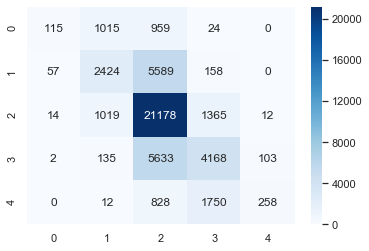

In [99]:
c_m = confusion_matrix(y_test, y_pred)
sns.heatmap(c_m, annot=True, cmap="Blues", fmt="d")

#### Sem outliers

In [100]:
bayes.fit(outX_train, outy_train)

y_pred = bayes.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.06      0.10      2113
           1       0.52      0.30      0.38      8228
           2       0.62      0.89      0.73     23588
           3       0.55      0.42      0.48     10041
           4       0.68      0.09      0.16      2848

    accuracy                           0.60     46818
   macro avg       0.59      0.35      0.37     46818
weighted avg       0.59      0.60      0.55     46818



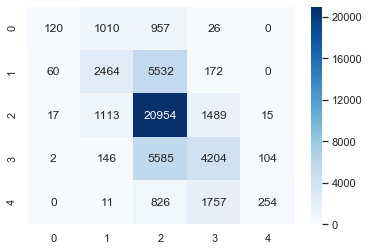

In [101]:
c_m = confusion_matrix(y_test, y_pred)
sns.heatmap(c_m, annot=True, cmap="Blues", fmt="d")

#### ENNR

In [102]:
bayes.fit(ennrX_train, ennry_train)

y_pred = bayes.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.06      0.12      2113
           1       0.53      0.29      0.38      8228
           2       0.61      0.90      0.73     23588
           3       0.56      0.39      0.46     10041
           4       0.71      0.07      0.12      2848

    accuracy                           0.60     46818
   macro avg       0.61      0.34      0.36     46818
weighted avg       0.59      0.60      0.55     46818



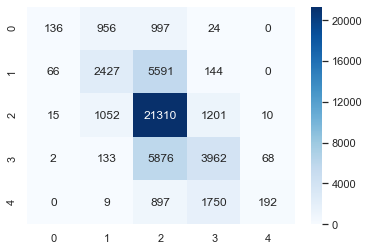

In [103]:
c_m = confusion_matrix(y_test, y_pred)
sns.heatmap(c_m, annot=True, cmap="Blues", fmt="d")

### Regression
- Regressão baseada na probablidade calculada de cada classe por instância no Naive Bayes

In [104]:
import numpy as np

bayes.fit(X_train, y_train)

y_prob = bayes.predict_proba(X_test)
y_pred = []

temp_classes = (bayes.classes_ + 1)
for prob in y_prob:
    pred = 0
    for i in range(len(prob)):
        pred += prob[i] * temp_classes[i]
    y_pred.append(pred/sum(prob) - 1)


print(y_test.describe())
    
mean_squared_error(y_test, y_pred)

count    46818.000000
mean         2.070123
std          0.899537
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: Sentimento, dtype: float64


0.47598100426601636

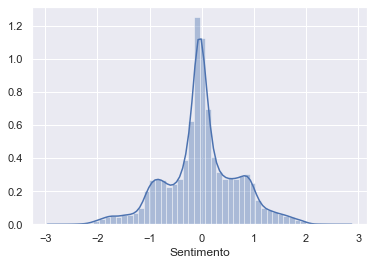

In [105]:
diff = (y_test - y_pred)
sns.set(color_codes=True)
sns.distplot(diff)

## Ensemble
- Considerando os melhores classificadores e regressores, baseado no critério de melhor acurácia e F1-score por classe para classificadores, e menor mean squared error para regressores, decidi criar um ensemble regressor visando melhorar o MSE dos outros regressores
- O LinearSVC e LogisticRegression foram os classificadores que tiveram melhor desempenho. O svm em termos de acurácia e o regressor logístico em termos de melhor classificação por classe, como é possível observar na matriz de cofusão
- Os melhores regressores foram o LinearSVR e Ridge, ambos com MSE na ordem de 0.37 e 0.36

In [181]:
svc = svm.LinearSVC(random_state=42)
svr = svm.LinearSVR(random_state=42)
ridge = Ridge(random_state=42)
logreg = LogisticRegression(solver='saga', max_iter=100, random_state=0, class_weight='balanced', n_jobs=-1, C=1e5)

custom_reg = ensemble.VotingRegressor([('logreg', logreg), ('ridge', ridge), ('svr', svr), ('svc', svc)],
                                      weights=[.5, 2, 2, 1], n_jobs=-1)

%time custom_reg.fit(X_train, y_train)

%time y_pred=custom_reg.predict(X_test)

mean_squared_error(y_test, y_pred)

Wall time: 42.8 s
Wall time: 76 ms


0.3479911309924574

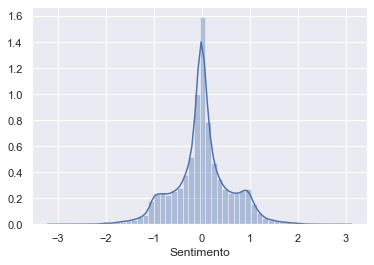

In [182]:
diff = (y_test - y_pred)
sns.set(color_codes=True)
sns.distplot(diff)

In [183]:
%time custom_reg.fit(outX_train, outy_train)

%time y_pred=custom_reg.predict(X_test)

mean_squared_error(y_test, y_pred)

Wall time: 38.2 s
Wall time: 39 ms


0.35467122352408914

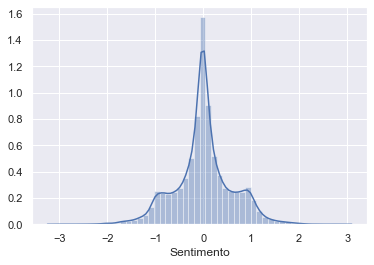

In [184]:
diff = (y_test - y_pred)
sns.set(color_codes=True)
sns.distplot(diff)

In [185]:
%time custom_reg.fit(ennrX_train, ennry_train)

%time y_pred=custom_reg.predict(X_test)

mean_squared_error(y_test, y_pred)

Wall time: 36.9 s
Wall time: 45 ms


0.3503145570848155

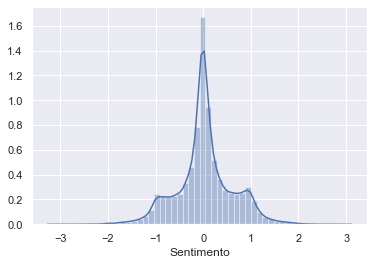

In [186]:
diff = (y_test - y_pred)
sns.set(color_codes=True)
sns.distplot(diff)

## Conclusão

> No pre-processamento foi seguido primeiramente o procedimento padrão de vetorização dos textos, sendo escolhido o algoritmo TF-IDF por ser mais representativo e conter mais informações relevantes que apenas uma representação booleana ou contagem

> Aliado a isso foi também feita a stemmização das palavras em radicais para diminuir a dimensionalidade do problema; não surtiu grandes efeitos nos resultados dos algoritmos mas com certeza diminuiu o tempo de execução

> O uso de stop words piorou o desempenho dos algoritmos então foi prontamente descartado

> Foram geradas mais duas bases de treino numa tentativa de melhorar a predição dos algoritmos:
> - Remoção de outliers: A remoção de outliers utilizando o Local Outlier Factor visava o melhor treinamento por noise canceling. Mas infelizmente além de tomar um tempo considerável, ela teve um resultado um pouco melhor apenas no Rocchio
> - Edited Nearest Neighbor Rule: Um algoritmo que também toma certo tempo, mas que retira todos as instâncias do conjunto de treinamento que são classificadas incorretamente. Dessa forma, elimina as instâncias na fronteira entre classes deixando os "clusters" mais bem definidos e sem muita interface. Teve resultado positivo apenas na regressão logística

> Apesar de muito lentos e pouco beneficentes, ambos algoritmos acima ajudam a reduzir o tamanho do dataset sem comprometer muito a capacidade de predição deles; obtiveram resultados semelhantes  
---
> Foram seguidos alguns algoritmos academica e empiricamente recomendados para processamento de texto e análise de sentimento; sendo sua maioria algoritmos lineares como support vector machines e ridge, também naive bayes e também algoritmo baseado em instâncias como o rocchio (nearest centroid)

> Os regressores, apesar de alguns terem um MSE maior que outros, são melhores na interpretabilidade no sentido de que mesmo que errem o valor ainda pode se encontrar próximo do desejado e ter uma melhor noção de predição, e em todos os gráficos demonstrados tiveram sua distribuição de erro próxima a `0`.

> Notadamente, pelo fato de existirem 5 classes, os classificadores não tiveram bom desempenho. Quanto mais classes (e com uma base desbalanceada numa distribuição normal entre classes) mais difícil para um classificador predizer corretamente o alvo

> Dessa forma, decidi criar um ensemble regressor de classificadores e regressores que mais se deram bem. O LinearSVC teve boa acurácia mas não teve um bom F1-score por classes, favorecendo a classe majoritária, diferentemente da regressão logística que teve um desempenho melhor de forma geral. Os melhores regressores segundo o MSE foram o Ridge e o LinearSVR, com desempenho, ao meu ver, satisfatórios.

> O ensemble conseguiu melhorar ainda mais o MSE dos outros regressores, tendo assim um resultado positivo e sem custos maiores, executando em tempo satisfatório
---
> Abaixo se encontram mais observações sobre outras abordagens para além do citado acima

## Indo além
### Mudança na classificação

> Como dito anteriormente, um alto número de classes leva a uma classificação mais precária, abaixo se encontra o que seria a adaptação de `{ "muito ruim", "ruim", "neutro", "bom", "muito bom" }` para `{ "ruim", "neutro", "bom" }`

> Sendo que a avaliação é feita por 3 conjuntos diferentes de labels binários, conjuntamente eles podem aproximar melhor do alvo

> É notável a melhora na predição do classificador LinearSVC e do regressor Ridge, tanto por diminuir o conflito e interseção entre classes quanto por balancear melhor as classes dentro do dataset

In [152]:
y0_train = pd.Series((y_train < 2), index=y_train.index)
y2_train = pd.Series((y_train == 2), index=y_train.index)
y4_train = pd.Series((y_train > 2), index=y_train.index)
y0_test = pd.Series((y_test < 2), index=y_test.index)
y2_test = pd.Series((y_test == 2), index=y_test.index)
y4_test = pd.Series((y_test > 2), index=y_test.index)

labels_train = [y0_train, y2_train, y4_train]
labels_test = [y0_test, y2_test, y4_test]

In [187]:
preds = []
LSVC = svm.LinearSVC(random_state=42)
for i in range(len(labels_train)):
    LSVC.fit(X_train, labels_train[i])
    preds.append(LSVC.predict(X_test))
    acc = accuracy_score(labels_test[i], preds[-1])
    print(f'{acc:.2%}')

86.95%
75.11%
86.43%


In [188]:
preds = []
RIDGE = Ridge(random_state=42)
for i in range(len(labels_train)):
    RIDGE.fit(X_train, labels_train[i])
    preds.append(RIDGE.predict(X_test))
    error = mean_squared_error(labels_test[i], preds[-1])
    print(error)


0.09923324323571742
0.17505754477489852
0.1086705865516074
